In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sympy
from sympy import Symbol, solve
from datetime import datetime
from numpy import pi, sin, cos, tan, arcsin, arccos, arctan, sqrt
from sklearn.preprocessing import MinMaxScaler
from skspatial.objects import Circle, Line
from numba import njit
import random

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
def cal_distance(m1xy, m2xy):
    # 计算二维距离
    dis = np.linalg.norm(m1xy - m2xy)
    return dis

In [3]:
def cal_mod_length(x):
    return sqrt(x[0]**2+x[1]**2)

In [4]:
PHI = 39.4 / 180 * pi
ST = [9.0, 10.5, 12.0,  13.5, 15.0]
D = [(datetime(2023,i,21)-datetime(2023,3,21)).days for i in range(1, 13)]
h_t = 80 # 集热器中心高度
h_max = 84 # 塔顶端高度
h_m = 4  # 定日镜中心高度
m_length, m_width = 6, 6
m_x_bound, m_y_bound = [-3,3], [-3,3] # 定日镜坐标边界
t_x_bound, t_z_bound = [-3.5, 3.5], [0, h_max]

In [5]:
mirrors_xy = pd.read_excel("EB布局13.xlsx").values
center = (0, 250)
m_xy = mirrors_xy
m_in_xy = []
for xy in m_xy:
    if cal_distance(xy, center) < 350:
        m_in_xy.append(xy)
m_in_xy = np.array(m_in_xy)
mirrors_xy = m_in_xy
mirrors_xyz = np.insert(mirrors_xy, 2, values=h_m, axis=1)

In [6]:
for k, mirror_xy in enumerate(mirrors_xy):
    mirrors_xyz[k,2] = 4+(6-4)*cal_mod_length(mirror_xy)/600

In [44]:
pd.DataFrame(mirrors_xyz[:,2]).to_excel("z.xlsx")

In [7]:
mirrors_xyz[:,2].mean()

5.030880597056025

## 计算太阳高度角，方位角

In [8]:
def cal_omega(st):
    # 计算太阳时角
    return pi / 12 * (st - 12)

def cal_delta(d):
    # 计算太阳赤纬角
    sin_delta = sin(2*pi*d/365) * sin(2*pi*23.45/360)
    return arcsin(sin_delta)

def scale_in_min_max(num, min=-1, max=1):
    # 将结果限制在范围内
    if (num < min): return min
    elif (num > max): return max
    else: return num

def cal_alpha_and_gamma_s(d, st):
    # 计算太阳高度角和方位角
    omega = cal_omega(st)
    delta = cal_delta(d)
    sin_alpha_s = cos(delta)*cos(PHI)*cos(omega) + sin(delta)*sin(PHI)
    sin_alpha_s = scale_in_min_max(sin_alpha_s)
    alpha_s = arcsin(sin_alpha_s)
    cos_gamma_s = (sin(delta) - sin(alpha_s) * sin(PHI)) / ((cos(alpha_s) * cos(PHI)))
    cos_gamma_s = scale_in_min_max(cos_gamma_s)
    gamma_s = arccos(cos_gamma_s)
    if (st > 12): 
        gamma_s = 2*pi - gamma_s
    return alpha_s, gamma_s

In [9]:
alpha_mat = np.zeros((12, 5))
gamma_mat = np.zeros((12, 5))
for i, d in enumerate(D):
    for j, st in enumerate(ST):
        alpha, gamma = cal_alpha_and_gamma_s(d, st)
        alpha_mat[i,j] = alpha
        gamma_mat[i,j] = gamma

## 计算定日镜俯仰角，方位角

In [10]:
def cal_S_r(mirror_xyz):
    # 计算反射光线单位向量
    O = np.array([0 ,0, h_t])
    O_A = np.array(mirror_xyz)
    v = O - O_A
    v = v / np.linalg.norm(v)
    return v

In [11]:
def cal_S_i(alpha, gamma):
    # 计算入射光线单位向量
    # alpha, gamma是弧度制
    x = -cos(alpha) * cos(gamma-pi/2)
    y = cos(alpha) * sin(gamma-pi/2)
    z = -sin(alpha)
    return np.array([x, y, z])

In [12]:
# 计算定日镜法向量
S_i_mat = np.zeros((12, 5, 3))
S_r_mat = np.zeros((12, 5, *mirrors_xyz.shape))
S_n_mat = np.zeros((12, 5, *mirrors_xyz.shape))
for i, d in enumerate(D):
    for j, st in enumerate(ST):
        alpha, gamma = cal_alpha_and_gamma_s(d, st)
        S_i = cal_S_i(alpha, gamma)
        S_i_mat[i,j] = S_i
        for k, mirror_xyz in enumerate(mirrors_xyz):
            S_r = cal_S_r(mirror_xyz)
            S_n = (S_r - S_i) / np.linalg.norm(S_r - S_i)
            S_r_mat[i,j,k] = S_r
            S_n_mat[i,j,k] = S_n

In [13]:
def cal_theta(S_n):
    # 计算定日镜俯仰角，方位角
    # 俯仰角：[0, pi/2)
    # 方位角：[0, 2*pi)
    x, y, z = S_n
    theta_z = arctan(sqrt(x**2 + y**2) / z)
    if theta_z < 0:
        theta_z = theta_z + pi
    theta_s = arcsin(x / sqrt(x**2 + y**2))
    if x > 0 and y < 0:
        theta_s = pi - theta_s
    elif x <= 0 and y >= 0:
        theta_s = 2*pi + theta_s
    elif x <= 0 and y < 0:
        theta_s = pi - theta_s
    return theta_z, theta_s

In [14]:
# 计算定日镜俯仰角，方位角
theta_mat = np.zeros((12, 5, mirrors_xyz.shape[0], 2))
for i, d in enumerate(D):
    for j, st in enumerate(ST):
        alpha, gamma = cal_alpha_and_gamma_s(d, st)
        S_i = cal_S_i(alpha, gamma)
        for k, mirror_xyz in enumerate(mirrors_xyz):
            S_r = cal_S_r(mirror_xyz)
            S_n = (S_r - S_i) / np.linalg.norm(S_r - S_i)
            theta_z, theta_s = cal_theta(S_n)
            theta_mat[i,j,k] = [theta_z, theta_s]

## 计算简单效率

In [15]:
# 计算余弦效率
ita_cos_mat = np.zeros((12, 5, mirrors_xyz.shape[0]))
for i, d in enumerate(D):
    for j, st in enumerate(ST):
        alpha, gamma = cal_alpha_and_gamma_s(d, st)
        S_i = cal_S_i(alpha, gamma)
        neg_S_i = -S_i
        for k, mirror_xyz in enumerate(mirrors_xyz):
            ita_cos = S_n_mat[i,j,k] @ neg_S_i
            ita_cos_mat[i,j,k] = ita_cos 
            
print("年平均余弦效率:", ita_cos_mat.mean())
for i, d in enumerate(D):
    print(f"{i+1:2}月平均余弦效率:", ita_cos_mat[i].mean())

年平均余弦效率: 0.8622461709338957
 1月平均余弦效率: 0.8897187286591643
 2月平均余弦效率: 0.8825629962069862
 3月平均余弦效率: 0.8688880167663587
 4月平均余弦效率: 0.8474094503945871
 5月平均余弦效率: 0.8276575119549442
 6月平均余弦效率: 0.819235841590212
 7月平均余弦效率: 0.8279208042105907
 8月平均余弦效率: 0.848507923073741
 9月平均余弦效率: 0.8697936965226996
10月平均余弦效率: 0.8837669394875843
11月平均余弦效率: 0.8901067982791089
12月平均余弦效率: 0.8913853440607714


In [49]:
# 计算余弦效率
ita_cos_mat = np.zeros((12, 5, mirrors_xyz.shape[0]))
for i, d in enumerate(D):
    for j, st in enumerate(ST):
        alpha, gamma = cal_alpha_and_gamma_s(d, st)
        S_i = cal_S_i(alpha, gamma)
        neg_S_i = -S_i
        for k, mirror_xyz in enumerate(mirrors_xyz):
            ita_cos = S_n_mat[i,j,k] @ neg_S_i
            ita_cos_mat[i,j,k] = ita_cos 
            
print("年平均余弦效率:", ita_cos_mat.mean())
for i, d in enumerate(D):
    print(ita_cos_mat[i].mean())

年平均余弦效率: 0.8622461709338957
0.8897187286591643
0.8825629962069862
0.8688880167663587
0.8474094503945871
0.8276575119549442
0.819235841590212
0.8279208042105907
0.848507923073741
0.8697936965226996
0.8837669394875843
0.8901067982791089
0.8913853440607714


In [16]:
# 计算大气透射率
def cal_ita_at(mirror_xyz):
    d = np.linalg.norm(mirror_xyz - np.array([0, 0, h_t]))
    return 0.99321 - 0.0001176*d + 1.97*10**(-8)*d**2
ita_at_mat = np.zeros(mirrors_xyz.shape[0])
for i, mirror_xyz in enumerate(mirrors_xyz):
    ita_at_mat[i] = cal_ita_at(mirror_xyz)

## 计算阴影遮挡

In [17]:
# 计算旋转矩阵
def cal_rot_mat(theta_z, theta_s):
    # 根据俯仰角和方位角，计算旋转矩阵
    beta, gamma = theta_z, theta_s
    sb, cb, sg, cg = sin(beta), cos(beta), sin(gamma), cos(gamma)
    return np.array([[cb*cg, -sg, sb*cg],
                     [sg*cb, cg,  sb*sg],
                     [-sb,   0,   cb]])

rot_mats = np.zeros((12, 5, mirrors_xyz.shape[0], 3, 3))
for i, _ in enumerate(D):
    for j, _ in enumerate(ST):
        for k, _ in enumerate(mirrors_xyz):
            theta_z, theta_s = theta_mat[i,j,k]
            rot_mats[i,j,k] = cal_rot_mat(theta_z, theta_s)

In [18]:
@njit
def in_bound(x, bound):
    # 判断点是否出了边界
    if (x < bound[0] or x > bound[1]):
        return False
    return True

In [19]:
@njit
def a_blocked_by_b(xy, V_0, day_id, st_id, a_id, b_id, shoot_in):
    m_x_bound, m_y_bound = [-3,3], [-3,3] # 定日镜坐标边界
    # shoot_in参数是指光为入射光还是为反射光，可取bool值
    # 后缀为0, a, b指地面坐标系, a镜坐标系, b镜坐标系
    h1_a = np.array([*xy, 0])
    O_a = mirrors_xyz[a_id]
    O_b = mirrors_xyz[b_id]
    if (O_a[:2] - O_b[:2]) @ V_0[:2] <= 0 and shoot_in:
        return False
    elif (O_a[:2] - O_b[:2]) @ V_0[:2] > 0 and not shoot_in:
        return False
    a_rot_mat = rot_mats[day_id, st_id, a_id]
    b_rot_mat = rot_mats[day_id, st_id, b_id]
    h1_0 = a_rot_mat @ h1_a + O_a
    h1_b = b_rot_mat.T @ (h1_0 - O_b)
    V_b = b_rot_mat.T @ (V_0)
    x2_b = h1_b[0] - V_b[0]*h1_b[2]/ V_b[2]
    y2_b = h1_b[1] - V_b[1]*h1_b[2]/ V_b[2]
    h2_b = np.array([x2_b, y2_b, 0])
    if in_bound(x2_b, m_x_bound) and in_bound(y2_b, m_y_bound):
        return True
    return False

In [20]:
@njit
def a_blocked_by_tower(xy, day_id, st_id, a_id):
    t_x_bound, t_z_bound = [-3.5, 3.5], [0, 84]
    # 后缀为0, a, t指地面坐标系, a镜坐标系, 塔坐标系
    h1_a = np.array([*xy, 0])
    O_a = mirrors_xyz[a_id]
    if (O_a[1] <= 0):
        return False
    a_rot_mat = rot_mats[day_id, st_id, a_id]
    h1_0 = a_rot_mat @ h1_a + O_a
    alpha, gamma = alpha_mat[day_id,st_id], gamma_mat[day_id,st_id]
    t_xy_rot_mat = np.array([[-cos(gamma), -sin(gamma)],
                             [sin(gamma), -cos(gamma)]])
    xy_t = t_xy_rot_mat @ h1_0[0:2]
    h1_t = np.array([*xy_t, h1_0[2]])
    if h1_t[1] >= 0:
        z_delta = tan(alpha)*sqrt(xy[0]**2 + xy[1]**2)
        z2_t = z_delta + h1_t[2]
        h2_t = np.array([h1_t[0], 0, z2_t]) # h2_t为射向h1点的光与塔平面的交点
        if t_x_bound[0] <=h2_t[0] <= t_x_bound[1] and t_z_bound[0] <= h2_t[2] <=t_z_bound[1]:
            return True
    return False

In [21]:
# 蒙特卡洛法，将定日镜等分成36个1m^2区域，每一个区域取中心点
x_mont = [-2.5, -1.5, -0.5, 0.5, 1.5, 2.5]
y_mont = [-2.5, -1.5, -0.5, 0.5, 1.5, 2.5]
xy_mont = np.array([[x, y] for x in x_mont for y in y_mont])

In [22]:
# 取每面定日镜的最近邻8面镜子，判断是否发生阴影或遮挡
MAX_NEAR_NUM = 8
near_mat = np.zeros((mirrors_xyz.shape[0], MAX_NEAR_NUM), dtype=np.int64)
for a_id, m1xy in enumerate(mirrors_xy):
    # 计算和其他镜子的距离
    distances = {}
    for b_id, m2xy in enumerate(mirrors_xy):
        if a_id == b_id:
            continue
        distances[b_id] = cal_distance(m1xy, m2xy)
    # 排序取出最近邻的8面镜子
    ls = []
    for new_b_id, _ in sorted(distances.items(), key = lambda kv:(kv[1], kv[0]))[:MAX_NEAR_NUM]:
        ls.append(new_b_id)
    near_mat[a_id] = ls

In [23]:
# 计算塔平面产生的阴影
blocked_mat = np.zeros((12, 5, mirrors_xyz.shape[0], len(x_mont), len(y_mont)), dtype=bool)
for i, d in enumerate(D):
    for j, st in enumerate(ST):
        for a_id, _ in enumerate(mirrors_xyz):
            for x_id, x in enumerate(x_mont):
                for y_id, y in enumerate(y_mont):
                    if a_blocked_by_tower([x,y], i, j, a_id):
                        # 被塔挡住，产生阴影
                        blocked_mat[i, j, a_id, x_id, y_id] = True

# 计算定光镜相互阴影
for i, d in enumerate(D):
    for j, st in enumerate(ST):
        S_i = S_i_mat[i, j]
        for a_id, near_pairs in enumerate(near_mat):
            for b_id in near_pairs:
                for x_id, x in enumerate(x_mont):
                    for y_id, y in enumerate(y_mont):
                        if a_blocked_by_b([x,y], S_i, i, j, a_id, b_id, shoot_in=True):
                            # 把入射光挡住，产生阴影
                            blocked_mat[i, j, a_id, x_id, y_id] = True

# 计算遮挡
for i, d in enumerate(D):
    for j, st in enumerate(ST):
        for a_id, near_pairs in enumerate(near_mat):
            S_r = S_r_mat[i,j,a_id]
            for b_id in near_pairs:
                for x_id, x in enumerate(x_mont):
                    for y_id, y in enumerate(y_mont):
                        if (not blocked_mat[i, j, a_id, x_id, y_id]) and \
                        a_blocked_by_b([x,y], S_r, i, j, a_id, b_id, shoot_in=False):
                            # 没有阴影，并且反射光被挡住
                            blocked_mat[i, j, a_id, x_id, y_id] = True

/home/crw/.mambaforge/lib/python3.10/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'xy' of function 'a_blocked_by_tower'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../tmp/ipykernel_45642/7360794.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/home/crw/.mambaforge/lib/python3.10/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'xy' of function 'a_blocked_by_b'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../tmp/ipykernel_45642/2728

In [24]:
ita_sb_mat = np.zeros((12, 5, mirrors_xyz.shape[0]))
for i, _ in enumerate(D):
    for j, _ in enumerate(ST):
        for k, _ in enumerate(mirrors_xyz):
            ita_sb_mat[i,j,k] = 1 - blocked_mat[i,j,k].sum() / (len(x_mont)*len(y_mont)) 

print("年平均阴影遮挡效率", ita_sb_mat.mean())
for i, _ in enumerate(D):
    print(f"{i+1:2}月平均阴影遮挡效率:", ita_sb_mat[i].mean())

年平均阴影遮挡效率 0.957962962962963
 1月平均阴影遮挡效率: 0.9407373113854596
 2月平均阴影遮挡效率: 0.9584533607681757
 3月平均阴影遮挡效率: 0.962863511659808
 4月平均阴影遮挡效率: 0.9675102880658437
 5月平均阴影遮挡效率: 0.9713751714677641
 6月平均阴影遮挡效率: 0.972997256515775
 7月平均阴影遮挡效率: 0.9713305898491084
 8月平均阴影遮挡效率: 0.9673045267489713
 9月平均阴影遮挡效率: 0.9624759945130316
10月平均阴影遮挡效率: 0.9572565157750342
11月平均阴影遮挡效率: 0.937517146776406
12月平均阴影遮挡效率: 0.9257338820301785


## 计算截断效率

In [25]:
MAX_ANGLE = 4.65 * 10**(-3)
angle_divide_num = 3
circle_divide_num = 6
tao_arr = np.linspace(0, 2*pi, circle_divide_num, endpoint=False)
sigma_arr = np.linspace(MAX_ANGLE, 0, angle_divide_num, endpoint=False)
light_mat = np.zeros((len(tao_arr) * len(sigma_arr), 3))
for i, tao in enumerate(tao_arr):
    for j, sigma in enumerate(sigma_arr):
        light_mat[len(sigma_arr)*i+j] = [sin(sigma)*cos(tao), sin(sigma)*sin(tao), cos(sigma)]

In [26]:
light_rot_mats = np.zeros((12, 5, mirrors_xyz.shape[0], 3, 3))
for i, d in enumerate(D):
    for j, st in enumerate(ST):
        for k, _ in enumerate(mirrors_xyz):
            S_r = S_r_mat[i,j,k]
            if (S_r[1] == 0):
                theta_x = pi / 2
            else:
                theta_x = arctan(-S_r[0] / S_r[1])
            x_s = np.array((cos(theta_x), sin(theta_x), 0))
            y_s = np.cross(S_r, x_s)
            # y_s = y_s / np.linalg.norm(y_s)
            light_rot_mats[i,j,k] = np.array((x_s, y_s, S_r)).T

In [27]:
R = 3.5
r_bound = [-3.5, 3.5]
machine_bound = [76, 84]
circle = Circle([0, 0], R)

def light_meet_machine(xy, light_0, day_id, st_id, m_id):
    m, n, l = light_0
    h1_a = np.array([*xy, 0])
    O_a = mirrors_xyz[a_id]
    rot_mat = rot_mats[day_id, st_id, a_id]
    h1_0 = rot_mat @ h1_a + O_a
    x1, y1, z1 = h1_0
    if (abs(m*y1 - n*x1) / sqrt(n**2+m**2) < R):
        line = Line([x1, y1], [x1+m, y1+n])
        point_a, point_b = circle.intersect_line(line)
        if abs(x1) < abs(y1):
            z = min(l*(point_a[1]-y1)/n+z1, l*(point_b[1]-y1)/n+z1)
        else:
            z = min(l*(point_a[0]-x1)/m+z1, l*(point_b[0]-x1)/m+z1)
        if in_bound(z, machine_bound):
            return True
    return False

In [28]:
trunc_mat = np.zeros((12, 5, mirrors_xyz.shape[0], len(x_mont), len(y_mont)))
for i, d in enumerate(D):
    for j, st in enumerate(ST):
        for k, mirror_xyz in enumerate(mirrors_xyz):
            for l_id, light in enumerate(light_mat):
                light_0 = light_rot_mats[i,j,k] @ light
                for x_id, x in enumerate(x_mont):
                     for y_id, y in enumerate(y_mont):
                        trunc_mat[i,j,k,x_id,y_id] = angle_divide_num * circle_divide_num
                        if blocked_mat[i,j,k,x_id,y_id]:
                            trunc_mat[i,j,k,x_id,y_id] = 0
                        if not blocked_mat[i,j,k,x_id,y_id] and \
                        not light_meet_machine([x,y], light_0, i, j, k):
                            trunc_mat[i,j,k,x_id,y_id] -= 1

/home/crw/.mambaforge/lib/python3.10/site-packages/numba/core/ir_utils.py:2149: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'bound' of function 'in_bound'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../tmp/ipykernel_45642/2962963315.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [29]:
ita_trunc_mat = np.zeros((12, 5, mirrors_xyz.shape[0]))
for i, d in enumerate(D):
    for j, st in enumerate(ST):
        for k, mirror_xyz in enumerate(mirrors_xyz):
            cnt = 0
            for x_id, x in enumerate(x_mont):
                 for y_id, y in enumerate(y_mont):
                    if not blocked_mat[i,j,k,x_id,y_id]:
                        cnt += 1
            if cnt == 0:
                ita_trunc_mat[i,j,k] = 0.94444444 # 对全阴影镜赋均值
            else:
                ita_trunc_mat[i,j,k] = trunc_mat[i,j,k].sum() / cnt / (angle_divide_num * circle_divide_num)

In [30]:
print("年平均截断效率:", ita_trunc_mat.mean())
for i, _ in enumerate(D):
    print(f"{i+1:2}月平均截断效率:", ita_trunc_mat[i].mean())

年平均截断效率: 0.9444703970232506
 1月平均截断效率: 0.944470516318596
 2月平均截断效率: 0.9444700433483699
 3月平均截断效率: 0.9444701645931414
 4月平均截断效率: 0.9444703551172687
 5月平均截断效率: 0.9444705456381041
 6月平均截断效率: 0.9444711171896358
 7月平均截断效率: 0.9444705456359093
 8月平均截断效率: 0.9444703551123306
 9月平均截断效率: 0.94447016459369
10月平均截断效率: 0.9444702122219784
11月平均截断效率: 0.9444704846630089
12月平均截断效率: 0.9444702598469746


## 计算DNI

In [31]:
G0 = 1.366
H = 3
a = 0.4237 - 0.00821*(6-H)**2
b = 0.5055 + 0.00595*(6.5-H)**2
c = 0.2711 + 0.01858*(2.5-H)**2
DNI_mat = np.zeros((12, 5))
for i, _ in enumerate(D):
    for j, _ in enumerate(ST):
        alpha, gamma = cal_alpha_and_gamma_s(D[i], ST[j])
        DNI_mat[i,j] = G0*(a + b*pow(np.e,-c/sin(alpha)))

## 计算光学效率

In [32]:
ita_ref = 0.92
ita_mat = np.zeros((12, 5, mirrors_xyz.shape[0]))
for i, _ in enumerate(D):
    for j, _ in enumerate(ST):
        for k, _ in enumerate(mirrors_xyz):
            ita_cos = ita_cos_mat[i,j,k]
            ita_at = ita_at_mat[i]
            ita_sb = ita_sb_mat[i,j,k]
            ita_trunc = ita_trunc_mat[i,j,k]
            ita_mat[i,j,k] = ita_cos * ita_sb * ita_at * ita_ref * ita_trunc

In [33]:
print("年平均光学效率:", ita_mat.mean())
for i, _ in enumerate(D):
    print(f"{i+1:2}月平均光学效率:", ita_mat[i].mean())

年平均光学效率: 0.6698217104798857
 1月平均光学效率: 0.6772466183210614
 2月平均光学效率: 0.6842957952085655
 3月平均光学效率: 0.6769223582353595
 4月平均光学效率: 0.6702480511224472
 5月平均光学效率: 0.6506505590508044
 6月平均光学效率: 0.6485351415301449
 7月平均光学效率: 0.6508215404880869
 8月平均光学效率: 0.66772530978677
 9月平均光学效率: 0.6773396279652776
10月平均光学效率: 0.6844030713021372
11月平均光学效率: 0.6820490299545112
12月平均光学效率: 0.667623422793463


## 计算热功率

In [38]:
E_mat = np.zeros((12, 5, mirrors_xyz.shape[0]))
for i, _ in enumerate(D):
    for j, _ in enumerate(ST):
        for k, _ in enumerate(mirrors_xyz):
            E_mat[i,j,k] = DNI_mat[i,j] * 8*8 * ita_mat[i,j,k]

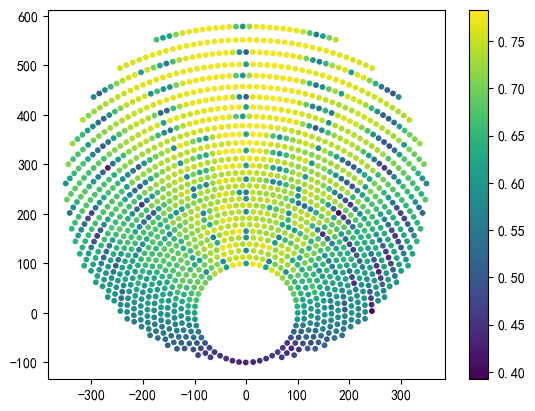

In [39]:
cm = matplotlib.colormaps['viridis']
sc = plt.scatter(mirrors_xy[:,0], mirrors_xy[:,1], c=ita_mat[i].mean(axis=0), s=10, cmap=cm)
plt.colorbar(sc)
plt.show()

In [40]:
print("年单位面积镜面平均输出热功率:", E_mat.mean() / 36)
for i, _ in enumerate(D):
    print(f"{i+1:2}月单位面积镜面平均输出热功率:", E_mat[i].mean() / 36)

年单位面积镜面平均输出热功率: 1.1532504182368701
 1月单位面积镜面平均输出热功率: 1.0496359495303305
 2月单位面积镜面平均输出热功率: 1.14733645348396
 3月单位面积镜面平均输出热功率: 1.1973952076998389
 4月单位面积镜面平均输出热功率: 1.226574328442795
 5月单位面积镜面平均输出热功率: 1.208839391541759
 6月单位面积镜面平均输出热功率: 1.2100126185818025
 7月单位面积镜面平均输出热功率: 1.2089758060316713
 8月单位面积镜面平均输出热功率: 1.2205555554706229
 9月单位面积镜面平均输出热功率: 1.1954147045457557
10月单位面积镜面平均输出热功率: 1.1380352440826436
11月单位面积镜面平均输出热功率: 1.0483300880484667
12月单位面积镜面平均输出热功率: 0.9878996713827952


In [41]:
print("年平均输出热功率:", (E_mat.sum() / 5 / 12))
for i, _ in enumerate(D):
    print(f"{i+1:2}月平均输出热功率(kW):", E_mat[i].sum() / 5)

年平均输出热功率: 67257.56439157427
 1月平均输出热功率(kW): 61214.76857660887
 2月平均输出热功率(kW): 66912.66196718455
 3月平均输出热功率(kW): 69832.08851305461
 4月平均输出热功率(kW): 71533.81483478381
 5月平均输出热功率(kW): 70499.51331471538
 6月平均输出热功率(kW): 70567.93591569073
 7月平均输出热功率(kW): 70507.46900776707
 8月平均输出热功率(kW): 71182.79999504672
 9月平均输出热功率(kW): 69716.58556910847
10月平均输出热功率(kW): 66370.21543489977
11月平均输出热功率(kW): 61138.61073498657
12月平均输出热功率(kW): 57614.30883504462
